In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
from torch import nn
import torch.nn.functional as F
import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

/home/tignjatov/anaconda3/envs/ml/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
transform = transforms.Compose(
    [transforms.Resize(32),
     transforms.Grayscale(),
     transforms.ToTensor(),
     transforms.Normalize(
            [0.5 for _ in range(1)], [0.5 for _ in range(1)]),
     ]
)

In [4]:
cgan_dataset = ImageFolder(root='../fake_mnist_datasets/cgan/',transform = transform)
cvae_dataset = ImageFolder(root='../fake_mnist_datasets/cvae/',transform = transform)
mnist_dataset = torchvision.datasets.MNIST(root='../mnist_datasets/data/',train=False,download=True,transform=transform)

In [5]:
cgan_dl = DataLoader(cgan_dataset, batch_size=32, shuffle=True)
cvae_dl = DataLoader(cvae_dataset, batch_size=32, shuffle=True)
mnist_dl = DataLoader(mnist_dataset, batch_size=32, shuffle=True)

In [6]:
class ConvNet(nn.Module):
   def __init__(self,no_classes):
      super().__init__()
      self.conv1 = nn.Conv2d(1,6,5)
      self.pool = nn.MaxPool2d(2,2)
      self.conv2 = nn.Conv2d(6,16,5)
      self.fc1 = nn.Linear(400,120)
      self.fc2 = nn.Linear(120,84)
      self.fc3 = nn.Linear(84,no_classes)
    
   def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
model = ConvNet(10)

In [8]:
model.load_state_dict(torch.load('../mnist_datasets/model/40_epochs_adam_mnist_classifier.pt'))

<All keys matched successfully>

In [9]:
model.to(device)

ConvNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [10]:
def test(model, test_loader, name):
    model.eval()
    pred_list  = []
    lab_list = []
    total = 0
    correct = 0
    with torch.no_grad():
        for img,lab in tqdm.tqdm(test_loader):
              img = img.to(device)
              lab = lab.to(device)

              outputs = model(img)
              _ , preds = torch.max(outputs,1)
              pred_list += preds.cpu().numpy().tolist()
              lab_list += lab.cpu().numpy().tolist()
              total += lab.size(0)
              correct += (preds == lab).sum().item()
    print(classification_report(lab_list, pred_list))
    sns.heatmap(confusion_matrix(lab_list, pred_list), annot=True)
    plt.savefig(f'{name}_conf_matrix.png')
    plt.show()

100%|██████████| 313/313 [00:02<00:00, 125.21it/s]


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.97      0.99      0.98       892
           6       1.00      0.98      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



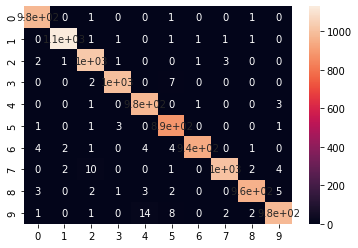

In [11]:
test(model, mnist_dl, 'original')

100%|██████████| 32/32 [00:00<00:00, 53.66it/s]


              precision    recall  f1-score   support

           0       0.94      0.98      0.96       100
           1       0.97      0.91      0.94       100
           2       0.93      0.90      0.91       100
           3       0.90      0.93      0.92       100
           4       0.93      0.97      0.95       100
           5       0.84      0.85      0.85       100
           6       0.93      0.99      0.96       100
           7       0.92      0.97      0.95       100
           8       0.96      0.82      0.89       100
           9       0.92      0.93      0.93       100

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.92      1000
weighted avg       0.93      0.93      0.92      1000



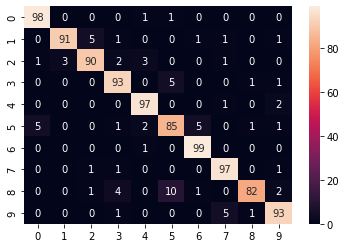

In [12]:
test(model, cgan_dl,'cgan')

100%|██████████| 32/32 [00:00<00:00, 68.96it/s]


              precision    recall  f1-score   support

           0       0.96      0.92      0.94       100
           1       0.66      0.38      0.48       100
           2       0.45      0.24      0.31       100
           3       0.03      0.06      0.04       100
           4       0.05      0.01      0.02       100
           5       0.17      0.22      0.19       100
           6       0.31      0.13      0.18       100
           7       0.17      0.35      0.22       100
           8       0.30      0.28      0.29       100
           9       0.37      0.41      0.39       100

    accuracy                           0.30      1000
   macro avg       0.35      0.30      0.31      1000
weighted avg       0.35      0.30      0.31      1000



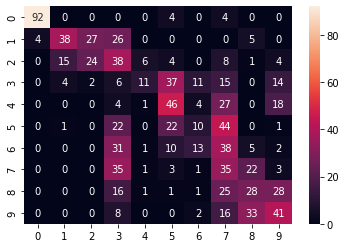

In [13]:
test(model, cvae_dl,'cvae')